In [1]:
import numpy as np
from astropy.table import Table, Column
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from edge_pydb import EdgeTable
from edge_pydb.conversion import msd_co
from edge_pydb.plotting import xy2hist, xy2binned
np.seterr(invalid='ignore')
# params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
# plt.rcParams.update(params)
plt.rcParams["scatter.edgecolors"] = 'none'

## Spatially resolved SF relations for EDGE, at 7" resolution (not deprojected)
### For CO, we use the 'smo' mask for detections but the 'str' mask for considering non-detections.  These differ in velocity width so we scale the 'str' mask noise down to the median velocity width for the 'smo' mask.
### For SFR, we load the extinction uncorrected values, as well as the pixel-wise Balmer decrement corrected values, and the "adopted" values where the extinction is calculated after smoothing the H$\alpha$ and H$\beta$ images.

In [2]:
# limit the columns we read to avoid information overload
sspcols = ['Name','ix','iy','mass_ssp_sm','sigstar_sm']
fluxcols = ['Name','ix','iy','flux_Halpha_sm','flux_Hbeta_sm','e_flux_Halpha_sm','e_flux_Hbeta_sm',
            'flux_sigsfr0_sm','flux_sigsfr_corr_sm','flux_sigsfr_adopt_sm','EW_Halpha_sm']
comomcols = ['Name','ix','iy','mom0_12','e_mom0_12','sigmol']

# Read the tables
globaltab = EdgeTable('edge_califa.csv', cols=['Name','caMass'])
cofluxtab = EdgeTable('edge_coflux_smo7.csv', cols=['Name','coNomaskDv_smo7','coSmoothDv_smo7'])
try: 
    fluxtab = EdgeTable('edge_carma.2d_smo7.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('edge_carma.2d_smo7.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('edge_carma.2d_smo7.hdf5', path='comom_smo', cols=comomcols)
    conomasktab = EdgeTable('edge_carma.2d_smo7.hdf5', path='comom_str', cols=['Name','ix','iy','e_mom0_12'])
    print('Working on full EDGE database')
except:
    fluxtab = EdgeTable('NGC4047.2d_smo7.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('NGC4047.2d_smo7.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('NGC4047.2d_smo7.hdf5', path='comom_smo', cols=comomcols)
    conomasktab = EdgeTable('NGC4047.2d_smo7.hdf5', path='comom_str', cols=['Name','ix','iy','e_mom0_12'])
    print('Working on NGC 4047 data')

Working on full EDGE database


In [3]:
print('Median unmasked velocity width is',np.nanmedian(cofluxtab['coNomaskDv_smo7']))
print('Median masked velocity width is',np.nanmedian(cofluxtab['coSmoothDv_smo7']))
nsefactor = np.sqrt(np.nanmedian(cofluxtab['coSmoothDv_smo7'])/np.nanmedian(cofluxtab['coNomaskDv_smo7']))
print('Noise estimates will be scaled down by',nsefactor)

Median unmasked velocity width is 860.0
Median masked velocity width is 420.0
Noise estimates will be scaled down by 0.6988362419217079


In [4]:
# consolidate the tables
fluxtab.join(ssptab, keys=['Name', 'ix', 'iy'])
fluxtab.join(cotab, keys=['Name', 'ix', 'iy'])
conomasktab['e_mom0_12'] *= nsefactor
conomasktab['e_mom0_12'].name = 'e_mom0max_12'
fluxtab.join(conomasktab, keys=['Name', 'ix', 'iy'])
fluxtab.join(globaltab)
print(fluxtab.colnames)

['Name', 'ix', 'iy', 'flux_Halpha_sm', 'flux_Hbeta_sm', 'e_flux_Halpha_sm', 'e_flux_Hbeta_sm', 'flux_sigsfr0_sm', 'flux_sigsfr_corr_sm', 'flux_sigsfr_adopt_sm', 'EW_Halpha_sm', 'mass_ssp_sm', 'sigstar_sm', 'mom0_12', 'e_mom0_12', 'sigmol', 'e_mom0max_12', 'caMass']


In [5]:
# Apply a 3-sigma cut to CO and Halpha
codet = fluxtab['mom0_12'] > 3*fluxtab['e_mom0_12']
sfdet = fluxtab['flux_Halpha_sm'] > 3*fluxtab['e_flux_Halpha_sm']
det = codet & sfdet
ndet = ~codet & sfdet

In [6]:
sfe_det = Table()
sfe_det['Name'] = fluxtab['Name'][det]
sfe_det['ICO'] = fluxtab['mom0_12'][det]
sfe_det['IHA'] = fluxtab['flux_Halpha_sm'][det]
sfe_det['sigmol'] = fluxtab['sigmol'][det]
sfe_det['sigsfr'] = fluxtab['flux_sigsfr_adopt_sm'][det]
sfe_det['sigsfr_cor'] = fluxtab['flux_sigsfr_corr_sm'][det]
sfe_det['sigsfr0'] = fluxtab['flux_sigsfr0_sm'][det]
sfe_det['sigstar'] = fluxtab['sigstar_sm'][det]
sfe_det['stmass'] = fluxtab['caMass'][det]
sfe_det['haew'] = abs(fluxtab['EW_Halpha_sm'][det])
sfe_det['t_dep'] = Column(sfe_det['sigmol'].quantity/sfe_det['sigsfr'].quantity)
sfe_det['f_mol'] = Column(sfe_det['sigmol'].quantity/sfe_det['sigstar'].quantity)
sfe_det['sigssfr'] = Column(sfe_det['sigsfr'].quantity/sfe_det['sigstar'].quantity)
sfe_det

Name,ICO,IHA,sigmol,sigsfr,sigsfr_cor,sigsfr0,sigstar,stmass,haew,t_dep,f_mol,sigssfr
,K km / s,1e-16 erg / (cm2 s),solMass / pc2,solMass / (Gyr pc2),solMass / (Gyr pc2),solMass / (Gyr pc2),solMass / pc2,dex(solMass),Angstrom,Gyr,,1 / Gyr
str23,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32
ARP220,4.2229695,0.2655836,18.15877,4.5245147,3.4479165,1.1125973,44.885147,10.9099006211689,10.386424,4.013418,0.40456077,0.10080205
ARP220,11.10943,0.34287092,47.770554,1.436386,12.304999,1.436386,40.745167,10.9099006211689,15.397308,33.25746,1.1724225,0.035252918
ARP220,10.225427,0.28539938,43.969337,1.1955881,nan,1.1955881,52.459324,10.9099006211689,14.497993,36.776325,0.8381606,0.022790765
ARP220,4.9249167,0.1637056,21.177143,0.68578005,nan,0.68578005,42.748394,10.9099006211689,10.357886,30.880373,0.4953904,0.016042242
ARP220,4.6806693,0.31773764,20.126879,3.8550994,2.6177208,1.3310866,43.9508,10.9099006211689,12.699126,5.2208457,0.45794111,0.08771397
ARP220,7.8781853,0.31534946,33.876198,7.708244,6.6359797,1.3210392,41.079655,10.9099006211689,14.049808,4.394801,0.8246466,0.1876414
ARP220,8.267965,0.23644416,35.552254,0.99049556,nan,0.99049556,53.491364,10.9099006211689,11.779383,35.893402,0.6646354,0.018516924
ARP220,3.3821652,0.12021709,14.543311,0.5036206,2.7286768,0.5036206,19.995127,10.9099006211689,8.050527,28.877514,0.7273428,0.025187168


In [7]:
sfe_ndet = Table()
sfe_ndet['Name'] = fluxtab['Name'][ndet]
sfe_ndet['sigmol'] = msd_co(3*fluxtab['e_mom0max_12'][ndet])
sfe_ndet['sigsfr'] = fluxtab['flux_sigsfr_adopt_sm'][ndet]
sfe_ndet['sigsfr_cor'] = fluxtab['flux_sigsfr_corr_sm'][ndet]
sfe_ndet['sigsfr0'] = fluxtab['flux_sigsfr0_sm'][ndet]
sfe_ndet['sigstar'] = fluxtab['sigstar_sm'][ndet]
sfe_ndet['stmass'] = fluxtab['caMass'][ndet]
sfe_ndet['haew'] = abs(fluxtab['EW_Halpha_sm'][ndet])
sfe_ndet['t_dep'] = Column(sfe_ndet['sigmol'].quantity/sfe_ndet['sigsfr'].quantity)
sfe_ndet['f_mol'] = Column(sfe_ndet['sigmol'].quantity/sfe_ndet['sigstar'].quantity)
sfe_ndet['sigssfr'] = Column(sfe_ndet['sigsfr'].quantity/sfe_ndet['sigstar'].quantity)
sfe_ndet

Name,sigmol,sigsfr,sigsfr_cor,sigsfr0,sigstar,stmass,haew,t_dep,f_mol,sigssfr
,solMass / pc2,solMass / (Gyr pc2),solMass / (Gyr pc2),solMass / (Gyr pc2),solMass / pc2,dex(solMass),Angstrom,Gyr,,1 / Gyr
str23,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32
ARP220,29.415976,1.2979357,4124.414,1.2979357,72.30398,10.9099006211689,12.3468485,22.663662,0.40683758,0.017951097
ARP220,29.09385,1.197291,22.726385,1.197291,61.781364,10.9099006211689,10.522485,24.29973,0.47091627,0.019379485
ARP220,28.9087,4.4187756,5.0440326,0.9784045,63.794662,10.9099006211689,8.3239565,6.5422425,0.45315236,0.0692656
ARP220,28.856451,2.7303152,1.9837341,0.9093213,62.901497,10.9099006211689,7.8415546,10.568909,0.45875618,0.043406203
ARP220,30.64108,0.27962524,nan,0.27962524,35.28558,10.9099006211689,5.114726,109.579094,0.86837405,0.007924632
ARP220,29.882069,0.7160927,nan,0.7160927,46.794147,10.9099006211689,7.7226133,41.72933,0.6385856,0.01530304
ARP220,30.098902,1.0582165,5.227885,1.0582165,75.281425,10.9099006211689,9.646978,28.443048,0.39981845,0.014056806
ARP220,29.901834,2.7919328,1.4028893,1.0138828,45.521652,10.9099006211689,9.33276,10.710084,0.6568706,0.061331976


## Spatially resolved CO vs. Halpha

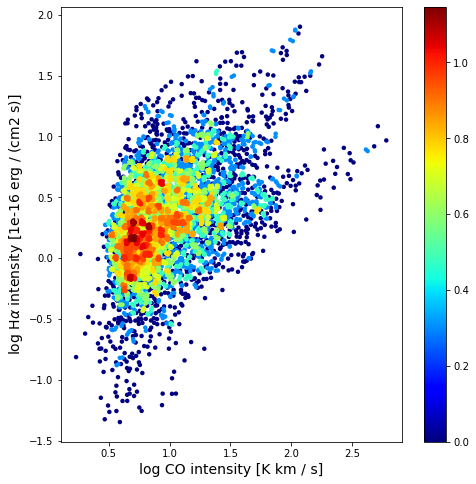

In [8]:
# Make the scatter plot (measured values)
x_det, y_det, z_det, *hist = xy2hist(sfe_det['ICO'], sfe_det['IHA'], log=True)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, cmap='jet')
plt.xlabel('log CO intensity ['+str(sfe_det['ICO'].unit)+']',fontsize=14)
plt.ylabel(r'log H$\alpha$ intensity ['+str(sfe_det['IHA'].unit)+']',fontsize=14)
cb = plt.colorbar(sc)

## Spatially resolved star formation law (compare extinction corrections)

==CO Detections==
Number of valid, invalid values: 5322 0
==Non-detections==
Number of valid, invalid values: 25167 0
==CO Detections==
Number of valid, invalid values: 5310 12
==Non-detections==
Number of valid, invalid values: 24572 595
==CO Detections==
Number of valid, invalid values: 5322 0
==Non-detections==
Number of valid, invalid values: 25167 0


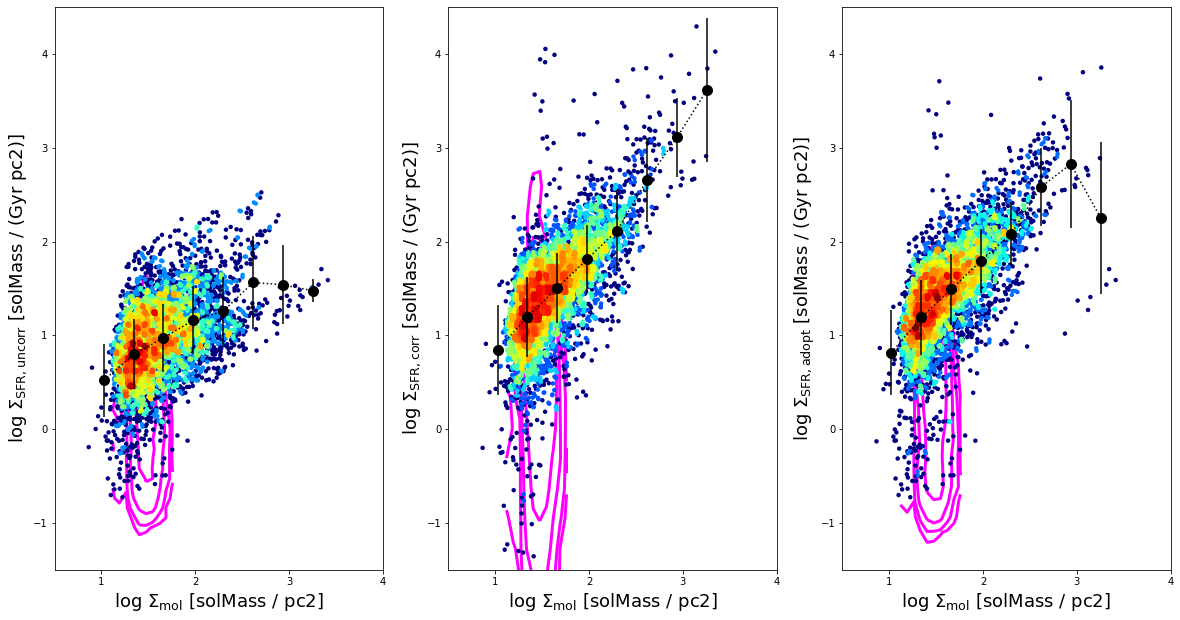

In [9]:
fig, axarr = plt.subplots(1, 3, figsize=(20,12))
ylbl = ['uncorr', 'corr', 'adopt']

for i, sfrcol in enumerate(['sigsfr0','sigsfr_cor','sigsfr']):
    # Select data to plot (must be loggable)
    valid = (sfe_det['sigmol'] > 0) & (sfe_det[sfrcol] > 0)
    print('==CO Detections==')
    print('Number of valid, invalid values:',len(np.nonzero(valid)[0]),len(np.nonzero(~valid)[0]))
    valid_ndet = (sfe_ndet['sigmol'] > 0) & (sfe_ndet[sfrcol] > 0)
    print('==Non-detections==')
    print('Number of valid, invalid values:',len(np.nonzero(valid_ndet)[0]),len(np.nonzero(~valid_ndet)[0]))

    # Get the plotting arrays
    x_det, y_det, z_det, *hist = xy2hist(sfe_det['sigmol'][valid], 
                                         sfe_det[sfrcol][valid], log=True)
    x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sfe_ndet['sigmol'][valid_ndet], 
                                             sfe_ndet[sfrcol][valid_ndet], log=True, bins=[10,30])

    # Make the scatter plot (physical values)
    sc = axarr[i].scatter(x_det, y_det, c=z_det, s=20, cmap='jet')
    x_bin, y_bin, y_err = xy2binned(sfe_det['sigmol'][valid], sfe_det[sfrcol][valid], bins=8)
    axarr[i].errorbar(x_bin, y_bin, yerr=y_err, color='k', marker='o', ms=10, ls=':', label='all')
    axarr[i].contour(hist2[0].transpose(),[10,30,100,300],
               extent=[hist2[1].min(),hist2[1].max(),
                       hist2[2].min(),hist2[2].max()],
               colors='magenta',linewidths=3,zorder=-1)
    axarr[i].set_xlabel(r'log $\Sigma_{\rm mol}$ ['+str(sfe_det['sigmol'].unit)+']',fontsize=18)
    axarr[i].set_ylabel(r'log $\Sigma_{\rm SFR,'+ylbl[i]+'}$ ['+str(sfe_det[sfrcol].unit)+']',fontsize=18)
    axarr[i].set_aspect('equal')
    axarr[i].set_xlim(0.5,4)
    axarr[i].set_ylim(-1.5,4.5)
    axarr[i].xaxis.set_major_locator(MultipleLocator(1))
    axarr[i].yaxis.set_major_locator(MultipleLocator(1))

## SF Law separated by stellar mass [cf. Fig. 17(a) of Bolatto+17]

Points from high-mass galaxies: 3039
Points from low-mass galaxies: 2283


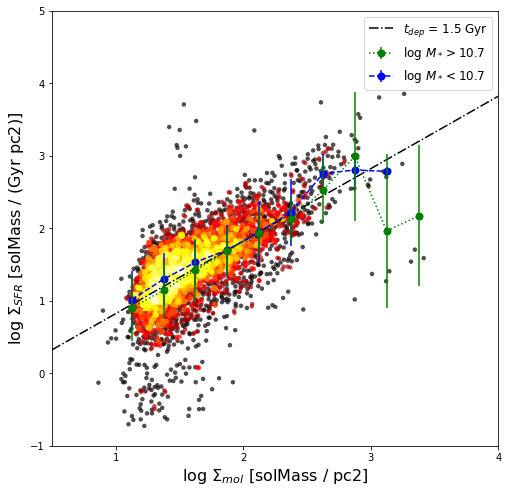

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
xlims=[0.5, 4]
x_det, y_det, z_det, *hist = xy2hist(sfe_det['sigmol'][valid], 
                                     sfe_det['sigsfr'][valid], log=True)
ax.scatter(x_det, y_det, c=z_det, s=20, cmap='hot', alpha=0.7)

valid = (sfe_det['sigmol'] > 0) & (sfe_det['sigsfr'] > 0)
himass = valid & (sfe_det['stmass'] > 10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = valid & (sfe_det['stmass'] <= 10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det['sigmol'][himass], 
                                      sfe_det['sigsfr'][himass], bins=10, range=[1,3.5])
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det['sigmol'][lomass], 
                                      sfe_det['sigsfr'][lomass], bins=10, range=[1,3.5])
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')

# 1.5 Gyr depletion time
xmod = np.linspace(xlims[0], xlims[1], num=10)
ymod = xmod - np.log10(1.5)
ax.plot(xmod, ymod, ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')

ax.set_xlabel(r'log $\Sigma_{mol}$ ['+str(sfe_det['sigmol'].unit)+']',fontsize=16)
ax.set_ylabel(r'log $\Sigma_{SFR}$ ['+str(sfe_det['sigsfr'].unit)+']',fontsize=16)
ax.set_xlim(xlims)
ax.set_ylim(-1,5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

Points from high-mass galaxies: 2794
Points from low-mass galaxies: 2527


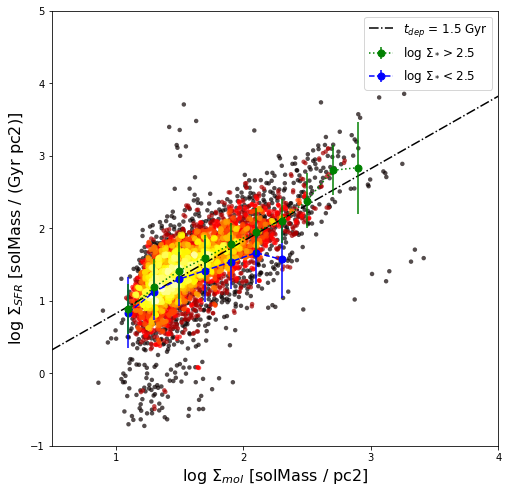

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
xlims=[0.5, 4]
x_det, y_det, z_det, *hist = xy2hist(sfe_det['sigmol'][valid], 
                                     sfe_det['sigsfr'][valid], log=True)
ax.scatter(x_det, y_det, c=z_det, s=20, cmap='hot', alpha=0.7)

valid = (sfe_det['sigmol'] > 0) & (sfe_det['sigsfr'] > 0)
himass = valid & (sfe_det['sigstar'] > 10**2.5)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = valid & (sfe_det['sigstar'] < 10**2.5)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det['sigmol'][himass], 
                                      sfe_det['sigsfr'][himass], bins=10, range=[1,3])
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $\Sigma_*>2.5$')
xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det['sigmol'][lomass], 
                                      sfe_det['sigsfr'][lomass], bins=10, range=[1,3])
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $\Sigma_*<2.5$')

# 1.5 Gyr depletion time
xmod = np.linspace(xlims[0], xlims[1], num=10)
ymod = xmod - np.log10(1.5)
ax.plot(xmod, ymod, ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')

ax.set_xlabel(r'log $\Sigma_{mol}$ ['+str(sfe_det['sigmol'].unit)+']',fontsize=16)
ax.set_ylabel(r'log $\Sigma_{SFR}$ ['+str(sfe_det['sigsfr'].unit)+']',fontsize=16)
ax.set_xlim(xlims)
ax.set_ylim(-1,5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

Points from high-mass galaxies: 2794
Points from low-mass galaxies: 2527


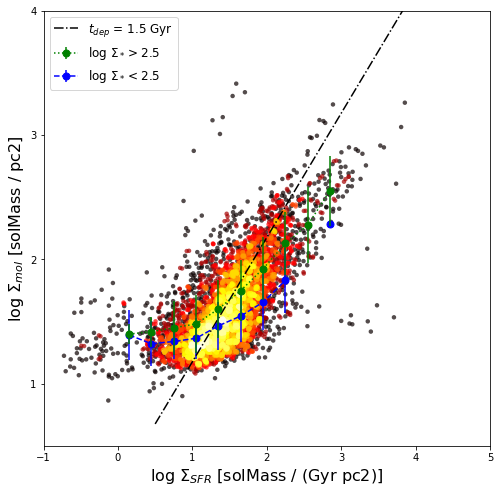

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
xlims=[0.5, 4]
x_det, y_det, z_det, *hist = xy2hist(sfe_det['sigsfr'][valid], 
                                     sfe_det['sigmol'][valid], log=True)
ax.scatter(x_det, y_det, c=z_det, s=20, cmap='hot', alpha=0.7)

valid = (sfe_det['sigmol'] > 0) & (sfe_det['sigsfr'] > 0)
himass = valid & (sfe_det['sigstar'] > 10**2.5)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = valid & (sfe_det['sigstar'] < 10**2.5)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det['sigsfr'][himass], 
                                      sfe_det['sigmol'][himass], bins=10, range=[0,3])
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $\Sigma_*>2.5$')
xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det['sigsfr'][lomass], 
                                      sfe_det['sigmol'][lomass], bins=10, range=[0,3])
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $\Sigma_*<2.5$')

# 1.5 Gyr depletion time
xmod = np.linspace(xlims[0], xlims[1], num=10)
ymod = xmod + np.log10(1.5)
ax.plot(xmod, ymod, ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')

ax.set_ylabel(r'log $\Sigma_{mol}$ ['+str(sfe_det['sigmol'].unit)+']',fontsize=16)
ax.set_xlabel(r'log $\Sigma_{SFR}$ ['+str(sfe_det['sigsfr'].unit)+']',fontsize=16)
ax.set_ylim(xlims)
ax.set_xlim(-1,5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

## Further comparisons of the 3 surface density variables

Plotting log $\Sigma_{\rm SFR}$ vs log $\Sigma_{\rm mol}$
Points from bin0: 313
Points from bin1: 2189
Points from bin2: 2151
Points from bin3: 596
Plotting log $\Sigma_{\rm mol}$ vs log $\Sigma_{*}$
Points from bin0: 2063
Points from bin1: 1812
Points from bin2: 523
Points from bin3: 99
Plotting log $\Sigma_{\rm SFR}$ vs log $\Sigma_{*}$
Points from bin0: 2345
Points from bin1: 2207
Points from bin2: 664
Points from bin3: 88


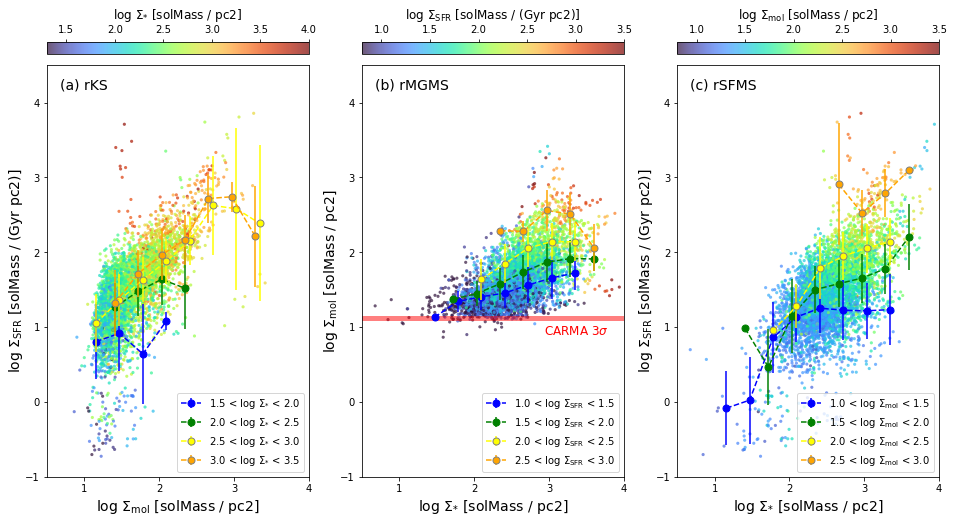

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(16,8), sharey=False)
plt.subplots_adjust(wspace=0.2)

valid = (sfe_det['sigmol'] > 0) & (sfe_det['sigsfr'] > 0) & (sfe_det['sigstar'] > 0)
sig_mol  = np.log10(sfe_det['sigmol'][valid])
sig_star = np.log10(sfe_det['sigstar'][valid])
sig_sfr  = np.log10(sfe_det['sigsfr'][valid])

xval = [sig_mol,  sig_star, sig_star]
yval = [sig_sfr,  sig_mol,  sig_sfr]
zval = [sig_star, sig_sfr,  sig_mol]
xlbl = [r'log $\Sigma_{\rm mol}$', r'log $\Sigma_{*}$', r'log $\Sigma_{*}$']
ylbl = [r'log $\Sigma_{\rm SFR}$', r'log $\Sigma_{\rm mol}$', r'log $\Sigma_{\rm SFR}$']
zlbl = [r'log $\Sigma_{*}$', r'log $\Sigma_{\rm SFR}$', r'log $\Sigma_{\rm mol}$']

lobin = [1.5, 1.0, 1.0]
vmin  = [1.3, 0.8, 0.8]
vmax  = [4.0, 3.5, 3.5]

for i in range(len(xval)):
    sc = axs[i].scatter(xval[i], yval[i], c=zval[i], s=10, cmap='turbo', 
                        alpha=0.7, vmin=vmin[i], vmax=vmax[i])
    print('Plotting {} vs {}'.format(ylbl[i],xlbl[i]))
    bin0 = (zval[i] > lobin[i]+0.0) & (zval[i] < lobin[i]+0.5)
    label0 = '{} < {} < {}'.format(lobin[i]+0.0,zlbl[i],lobin[i]+0.5)
    print('Points from bin0:',len(np.nonzero(bin0)[0]))
    bin1 = (zval[i] > lobin[i]+0.5) & (zval[i] < lobin[i]+1.0)
    label1 = '{} < {} < {}'.format(lobin[i]+0.5,zlbl[i],lobin[i]+1.0)
    print('Points from bin1:',len(np.nonzero(bin1)[0]))
    bin2 = (zval[i] > lobin[i]+1.0) & (zval[i] < lobin[i]+1.5)
    label2 = '{} < {} < {}'.format(lobin[i]+1.0,zlbl[i],lobin[i]+1.5)
    print('Points from bin2:',len(np.nonzero(bin2)[0]))
    bin3 = (zval[i] > lobin[i]+1.5) & (zval[i] < lobin[i]+2.0)
    label3 = '{} < {} < {}'.format(lobin[i]+1.5,zlbl[i],lobin[i]+2.0)
    print('Points from bin3:',len(np.nonzero(bin3)[0]))

    if i == 0:
        axs[i].text(0.05,0.95,'(a) rKS',size=14,ha='left',va='center',transform=axs[i].transAxes)
    if i == 1:
        axs[i].text(0.05,0.95,'(b) rMGMS',size=14,ha='left',va='center',transform=axs[i].transAxes)
        axs[i].axhline(1.12, ls='-', color='r', lw=5, alpha=0.5)
        axs[i].text(3.8,0.9,'CARMA 3$\sigma$',ha='right',color='r', size=12)
    elif i == 2:
        axs[i].text(0.05,0.95,'(c) rSFMS',size=14,ha='left',va='center',transform=axs[i].transAxes)

#         axs[i].axhline(1.02, ls='-', color='brown', lw=5, alpha=0.5)
#         axs[i].text(4.4,0.8,'GBT',ha='right',color='brown', alpha=0.5)
#         axs[i].axhline(0.52, ls='-', color='magenta', lw=5, alpha=0.5)
#         axs[i].text(4.4,0.3,'ACA',ha='right',color='magenta', alpha=0.5)

    xbin0, ybin0, ybin0_err = xy2binned(xval[i][bin0], yval[i][bin0], bins=8, 
                                        log=False, range=[1,3.5])
    axs[i].errorbar(xbin0, ybin0, yerr=ybin0_err, zorder=3,
                color='blue', marker='o', ms=7, ls='--', label=label0)
    xbin1, ybin1, ybin1_err = xy2binned(xval[i][bin1], yval[i][bin1], bins=8, 
                                        log=False, range=[1.25,3.75])
    axs[i].errorbar(xbin1, ybin1, yerr=ybin1_err, zorder=4,
                color='green', marker='o', ms=7, ls='--', label=label1)
    xbin2, ybin2, ybin2_err = xy2binned(xval[i][bin2], yval[i][bin2], bins=8, 
                                        log=False, range=[1,3.5])
    axs[i].errorbar(xbin2, ybin2, yerr=ybin2_err, zorder=5, mec='grey',
                color='yellow', marker='o', ms=7, ls='--', label=label2)
    xbin3, ybin3, ybin3_err = xy2binned(xval[i][bin3], yval[i][bin3], bins=8, 
                                        log=False, range=[1.25,3.75])
    axs[i].errorbar(xbin3, ybin3, yerr=ybin3_err, zorder=6, mec='grey',
                color='orange', marker='o', ms=7, ls='--', label=label3)

    axs[i].set_xlabel(xlbl[i]+' ['+str(xval[i].unit)+']',fontsize=14)
    axs[i].set_ylabel(ylbl[i]+' ['+str(yval[i].unit)+']',fontsize=14,labelpad=0)

    axs[i].set_xlim( 0.5, 4)
    axs[i].set_ylim(-1, 4.5)
    axs[i].set_aspect('equal')
    axs[i].xaxis.set_major_locator(MultipleLocator(1))
    axs[i].yaxis.set_major_locator(MultipleLocator(1))
    axs[i].legend(fontsize='medium', loc='lower right')
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('top', size='3%', pad=0.15)
    cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')
    cbar.set_label(zlbl[i]+' ['+str(zval[i].unit)+']', size=12, labelpad=6)
    cax.xaxis.set_label_position('top')
    cax.xaxis.set_ticks_position('top')
plt.savefig('threeviews.pdf',bbox_inches='tight')

Points from high-mass galaxies: 3038
Points from low-mass galaxies: 2283
Points from high-mass galaxies: 3038
Points from low-mass galaxies: 2283


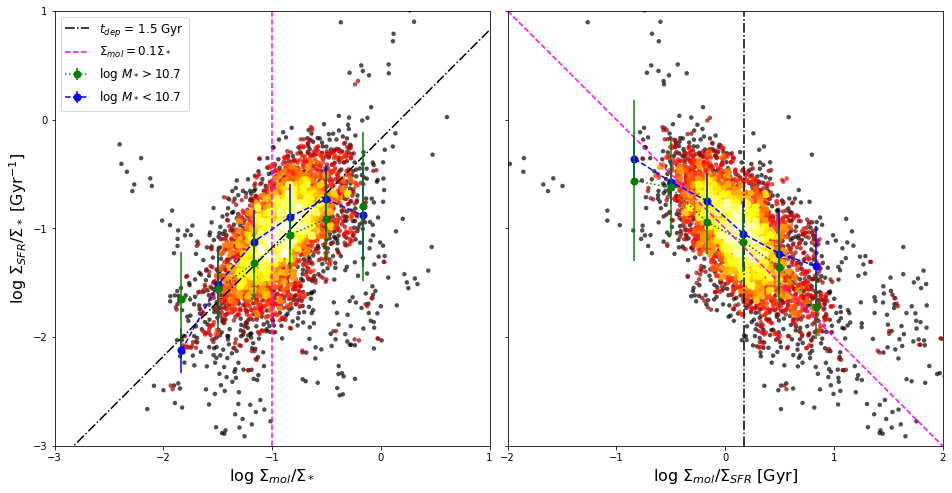

In [14]:
fig, axarr = plt.subplots(1, 2, figsize=(16,8), sharey=True)
plt.subplots_adjust(wspace=0.03)
xlbl = ['$\Sigma_{mol}$/$\Sigma_*$', '$\Sigma_{mol}$/$\Sigma_{SFR}$ [Gyr]']
xbinlim = [[-2,0], [-1,1]]
xlim = [[-3,1], [-2,2]]

for i, xcol in enumerate(['f_mol','t_dep']):

    valid = (sfe_det['sigssfr'] > 0) & (sfe_det[xcol] > 0)

    x_det, y_det, z_det, *hist = xy2hist(sfe_det[xcol][valid], 
                                         sfe_det['sigssfr'][valid], log=True)
    axarr[i].scatter(x_det, y_det, c=z_det, s=20, cmap='hot', alpha=0.7)

    himass = valid & (sfe_det['stmass'] > 10.7)
    print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
    lomass = valid & (sfe_det['stmass'] <= 10.7)
    print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

    xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det[xcol][himass], 
                                          sfe_det['sigssfr'][himass], bins=6, range=xbinlim[i])
    axarr[i].errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
                color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
    xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det[xcol][lomass], 
                                          sfe_det['sigssfr'][lomass], bins=6, range=xbinlim[i])
    axarr[i].errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
                color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')

    # Plot fiducial lines
    xmod = np.linspace(xlim[i][0], xlim[i][1], num=10)
    if i == 0:
        tdepmod = xmod - np.log10(1.5)
        axarr[i].plot(xmod, tdepmod, ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')
        axarr[i].axvline(-1, ls='--', color='magenta', label='$\Sigma_{mol} = 0.1\Sigma_*$')
        axarr[i].legend(fontsize='large')
        axarr[i].set_ylabel(r'log $\Sigma_{SFR}$/$\Sigma_*$ [Gyr$^{-1}$]',fontsize=16)
    else:
        axarr[i].axvline(np.log10(1.5), ls='-.', color='k')
        fmolmod = -xmod - 1
        axarr[i].plot(xmod, fmolmod, ls='--', color='magenta')
    axarr[i].set_xlabel('log '+xlbl[i],fontsize=16)
    axarr[i].set_xlim(xlim[i])
    axarr[i].set_ylim(-3,1)
    axarr[i].set_aspect('equal')
    axarr[i].xaxis.set_major_locator(MultipleLocator(1))
    axarr[i].yaxis.set_major_locator(MultipleLocator(1))

Points from high-mass galaxies: 3038
Points from low-mass galaxies: 2283
Points from high-mass galaxies: 3038
Points from low-mass galaxies: 2283


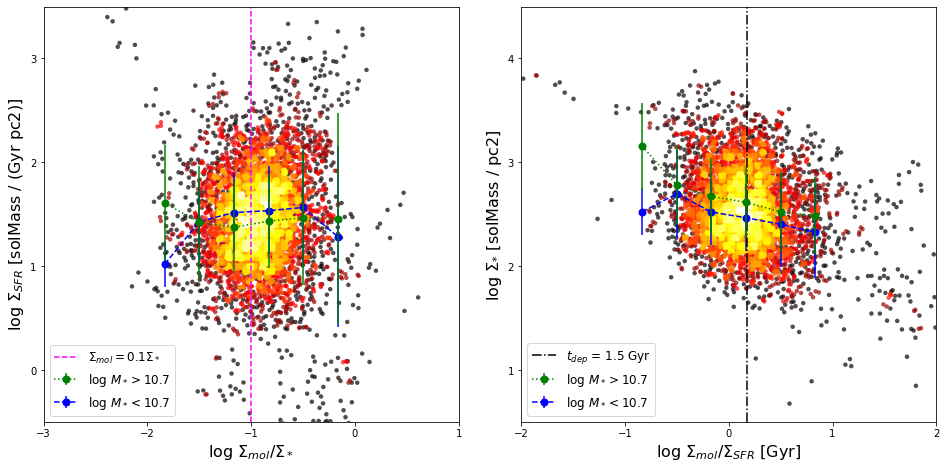

In [15]:
fig, axarr = plt.subplots(1, 2, figsize=(16,8))
plt.subplots_adjust(wspace=0.15)

xlbl = ['$\Sigma_{mol}$/$\Sigma_*$', '$\Sigma_{mol}$/$\Sigma_{SFR}$ [Gyr]']
xbinlim = [[-2,0], [-1,1]]
xlim = [[-3,1], [-2,2]]
ylim = [[-0.5,3.5], [0.5,4.5]]
xcols = ['f_mol','t_dep']
ycols = ['sigsfr', 'sigstar']

for i, xcol in enumerate(xcols):
    valid = (sfe_det[ycols[i]] > 0) & (sfe_det[xcol] > 0)
    x_det, y_det, z_det, *hist = xy2hist(sfe_det[xcol][valid], 
                                         sfe_det[ycols[i]][valid], log=True)
    axarr[i].scatter(x_det, y_det, c=z_det, s=20, cmap='hot', alpha=0.7)

    himass = valid & (sfe_det['stmass'] > 10.7)
    print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
    lomass = valid & (sfe_det['stmass'] <= 10.7)
    print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

    xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det[xcol][himass], 
                                          sfe_det[ycols[i]][himass], bins=6, range=xbinlim[i])
    axarr[i].errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
                color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
    xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det[xcol][lomass], 
                                          sfe_det[ycols[i]][lomass], bins=6, range=xbinlim[i])
    axarr[i].errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
                color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')

    # Plot fiducial lines
    if i == 0:
        axarr[i].axvline(-1, ls='--', color='magenta', label='$\Sigma_{mol} = 0.1\Sigma_*$')
        axarr[i].set_ylabel(r'log $\Sigma_{SFR}$'+' ['+str(sfe_det[ycols[i]].unit)+']',fontsize=16)
    else:
        axarr[i].axvline(np.log10(1.5), ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')
        axarr[i].set_ylabel(r'log $\Sigma_{*}$'+' ['+str(sfe_det[ycols[i]].unit)+']',fontsize=16)
    axarr[i].legend(fontsize='large',loc=3)
    axarr[i].set_xlabel('log '+xlbl[i],fontsize=16)
    axarr[i].set_xlim(xlim[i])
    axarr[i].set_ylim(ylim[i])
    axarr[i].set_aspect('equal')
    axarr[i].xaxis.set_major_locator(MultipleLocator(1))
    axarr[i].yaxis.set_major_locator(MultipleLocator(1))

## Depletion time vs. local stellar density or sSFR

==CO Detections==
Number of valid, invalid values: 5321 1
Points from high-mass galaxies: 3038
Points from low-mass galaxies: 2283
==Non-detections==
Number of valid, invalid values: 23058 2109
==CO Detections==
Number of valid, invalid values: 5321 1
Points from high-mass galaxies: 3038
Points from low-mass galaxies: 2283
==Non-detections==
Number of valid, invalid values: 23058 2109


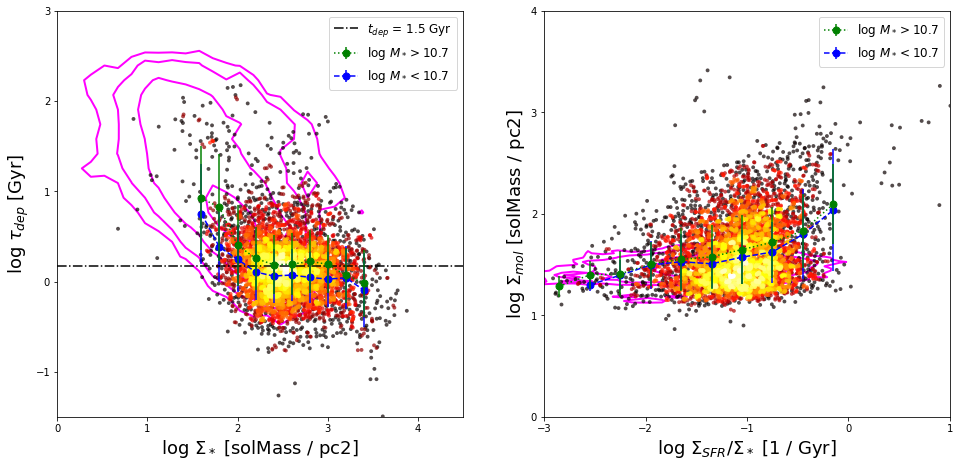

In [16]:
fig, axarr = plt.subplots(1, 2, figsize=(16,8))
xlbl = ['$\Sigma_*$', '$\Sigma_{SFR}$/$\Sigma_*$']
ycol = ['t_dep', 'sigmol']
xbinlim = [[1.5,3.5], [-3,0]]
for i, starcol in enumerate(['sigstar','sigssfr']):

    # Select data to plot (must be loggable)
    sstd_valid = ~np.isnan(sfe_det[starcol]) & (sfe_det[starcol]>0) & (sfe_det[ycol[i]]>0)
    print('==CO Detections==')
    print('Number of valid, invalid values:',len(np.nonzero(sstd_valid)[0]),len(np.nonzero(~sstd_valid)[0]))
    himass = sstd_valid & (sfe_det['stmass'] > 10.7)
    print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
    lomass = sstd_valid & (sfe_det['stmass'] <= 10.7)
    print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))
    sstd_valid_ndet = ~np.isnan(sfe_ndet[starcol]) & (sfe_ndet[starcol]>0) & (sfe_ndet[ycol[i]]>0)
    print('==Non-detections==')
    print('Number of valid, invalid values:',len(np.nonzero(sstd_valid_ndet)[0]),
          len(np.nonzero(~sstd_valid_ndet)[0]))

    x_det, y_det, z_det, *hist = xy2hist(sfe_det[starcol][sstd_valid], 
                                         sfe_det[ycol[i]][sstd_valid], log=True)
    x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sfe_ndet[starcol][sstd_valid_ndet], 
                                             sfe_ndet[ycol[i]][sstd_valid_ndet], 
                                             log=True, bins=[30,30])

    xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det[starcol][himass], 
                                          sfe_det[ycol[i]][himass], bins=10, range=xbinlim[i])
    xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det[starcol][lomass], 
                                          sfe_det[ycol[i]][lomass], bins=10, range=xbinlim[i])

    # Make the scatter plot
    axarr[i].scatter(x_det, y_det, c=z_det, s=15, cmap='hot', alpha=0.7)
    axarr[i].errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
                color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
    axarr[i].errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
                color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')
    axarr[i].contour(hist2[0].transpose(),[10,30,100,300],
               extent=[hist2[1].min(),hist2[1].max(),
                       hist2[2].min(),hist2[2].max()],
               colors='magenta',linewidths=2,zorder=-1)
    axarr[i].set_xlabel(r'log '+xlbl[i]+' ['+str(sfe_det[starcol].unit)+']',fontsize=18)
    
    if i == 0:
        axarr[i].axhline(np.log10(1.5), ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')
        axarr[i].set_xlim(0,4.5)
        axarr[i].set_ylabel(r'log $\tau_{dep}$ ['+str(sfe_det[ycol[i]].unit)+']',fontsize=18)
        axarr[i].set_ylim(-1.5,3)


    else:
        axarr[i].set_xlim(-3,1)
        axarr[i].set_ylabel(r'log $\Sigma_{mol}$ ['+str(sfe_det[ycol[i]].unit)+']',fontsize=18)
        axarr[i].set_ylim(0,4)
    axarr[i].set_aspect('equal')


    axarr[i].xaxis.set_major_locator(MultipleLocator(1))
    axarr[i].yaxis.set_major_locator(MultipleLocator(1))
    axarr[i].legend(fontsize='large')

## H$\alpha$ equivalent width vs. local sSFR

==CO Detections==
Number of valid, invalid values: 5321 1
Points from high-mass galaxies: 3038
Points from low-mass galaxies: 2283


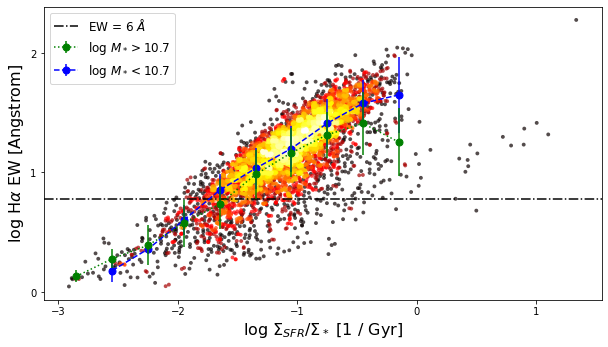

In [17]:
# Select data to plot (must be loggable)
ewvalid = ~np.isnan(sfe_det['sigssfr']) & (sfe_det['sigssfr']>0) & (sfe_det['haew']>0)
print('==CO Detections==')
print('Number of valid, invalid values:',len(np.nonzero(ewvalid)[0]),len(np.nonzero(~ewvalid)[0]))
himass = ewvalid & (sfe_det['stmass'] > 10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = ewvalid & (sfe_det['stmass'] <= 10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

x_det, y_det, z_det, *hist = xy2hist(sfe_det['sigssfr'][ewvalid], 
                                     sfe_det['haew'][ewvalid], log=True)

xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det['sigssfr'][himass], 
                                      sfe_det['haew'][himass], bins=10, range=[-3,0])
xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det['sigssfr'][lomass], 
                                      sfe_det['haew'][lomass], bins=10, range=[-3,0])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x_det, y_det, c=z_det, s=15, cmap='hot', alpha=0.7)
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')

ax.set_xlabel(r'log $\Sigma_{SFR}$/$\Sigma_*$ ['+str(sfe_det['sigssfr'].unit)+']',fontsize=16)
ax.set_ylabel(r'log H$\alpha$ EW ['+str(sfe_det['haew'].unit)+']',fontsize=16)
ax.set_aspect('equal')
ax.axhline(np.log10(6), ls='-.', color='k', label='EW = 6 $\AA$')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.legend(fontsize='large')

## H$_2$ vs. stellar surface density relation.  Here we select only on CO detection, ignoring H$\alpha$.

==CO Detections==
Number of valid, invalid values: 5341 318
Points from high-mass galaxies: 3046
Points from low-mass galaxies: 2295
==Non-detections==
Number of valid, invalid values: 27876 158761


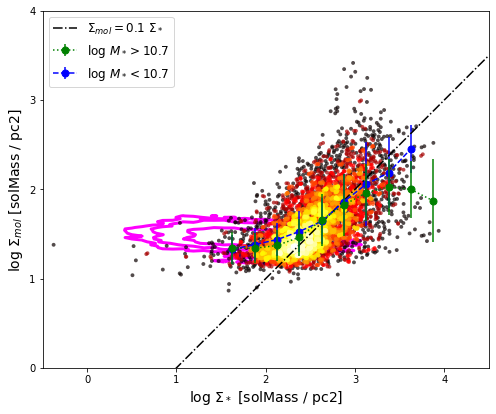

In [18]:
sigmol = fluxtab['sigmol'][codet]
sigstar = fluxtab['sigstar_sm'][codet]
h2s_valid = (sigmol>0) & (sigstar>0)
print('==CO Detections==')
print('Number of valid, invalid values:',len(np.nonzero(h2s_valid)[0]),len(np.nonzero(~h2s_valid)[0]))
himass = h2s_valid & (fluxtab['caMass'][codet] > 10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = h2s_valid & (fluxtab['caMass'][codet] <= 10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

sigmol_nd = msd_co(3*fluxtab['e_mom0max_12'][~codet])
sigstar_nd = fluxtab['sigstar_sm'][~codet]

h2s_valid_ndet = (sigmol_nd>0) & (sigstar_nd>0)
print('==Non-detections==')
print('Number of valid, invalid values:',len(np.nonzero(h2s_valid_ndet)[0]),len(np.nonzero(~h2s_valid_ndet)[0]))

x_det, y_det, z_det, *hist = xy2hist(sigstar[h2s_valid], 
                                     sigmol[h2s_valid], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sigstar_nd[h2s_valid_ndet], 
                                         sigmol_nd[h2s_valid_ndet], 
                                         log=True, bins=[40,40])

xhi_bin, yhi_bin, yhi_err = xy2binned(sigstar[himass], 
                                      sigmol[himass], bins=10, range=[1.5,4])
xlo_bin, ylo_bin, ylo_err = xy2binned(sigstar[lomass], 
                                      sigmol[lomass], bins=10, range=[1.5,4])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
xlims = [-0.5,4.5]
ax.scatter(x_det, y_det, c=z_det, s=15, cmap='hot', alpha=0.7)
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
ax.set_xlabel(r'log $\Sigma_*$ ['+str(sigmol.unit)+']',fontsize=14)
ax.set_ylabel(r'log $\Sigma_{mol}$ ['+str(sigstar.unit)+']',fontsize=14)
ax.set_aspect('equal')
xmod = np.linspace(xlims[0], xlims[1], num=10)
ymod = xmod - 1
ax.plot(xmod, ymod, ls='-.', color='k', label='$\Sigma_{mol}=0.1\ \Sigma_*$')
ax.set_xlim(xlims)
ax.set_ylim(0,4)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

## Identify which galaxies contribute the most pixels to the plot.

In [19]:
import pandas as pd
galname=fluxtab['Name'][codet]
df = pd.DataFrame(galname[h2s_valid])
pd.set_option('display.max_rows', 1001)
df2 = df['Name'].value_counts().to_frame()
print(df2)

              Name
NGC2253        140
NGC6060        134
NGC5908        124
NGC6361        118
NGC5480        114
NGC4047        112
NGC5218        106
NGC6301        100
NGC5980         99
NGC2639         97
UGC04132        94
NGC6478         94
NGC5633         93
NGC5614         89
NGC2906         88
NGC6155         85
NGC2347         84
NGC5953         81
ARP220          78
IC4566          74
NGC2410         73
NGC0523         73
NGC6186         73
UGC05111        71
IC2247          70
IC0944          69
NGC5406         68
NGC0551         67
UGC10123        66
NGC5016         66
NGC3811         62
NGC4210         59
UGC08107        59
NGC6004         58
IC0480          56
IC2487          55
NGC5520         55
NGC4711         54
UGC09665        53
UGC04029        53
IC1199          51
NGC3994         50
NGC5056         50
UGC09476        49
NGC0477         49
UGC10043        48
NGC3815         47
UGC10384        47
NGC4644         47
UGC09537        46
NGC5394         45
IC5376      